In [447]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
import os
from tqdm import tqdm
import json as js
import codecs
import subprocess

In [472]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = False

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22


In [384]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)
    #return lst2
    #print(lst2,cliffsDelta(lst1,lst2)) # should return False

# LOAD DATAFRAMES 

In [471]:
efforts=pd.read_json('./scam_efforts.json')
efforts['prev_date']=efforts['prev_date'].apply(lambda x: datetime.
                                                fromtimestamp(float(x)).
                                                strftime('%Y-%m-%d %H:%M:%S')
                                               )

for x in ['diff_ccn','diff_funs','diff_loc']:
    efforts[x]=efforts[x].apply(lambda x: abs(x))
efforts.head(2)

,ccn,closed_at,created_at,date,diff_ccn,diff_funs,diff_loc,file_path,funs,hash,is_test,issue,loc,merged,merged_at,prev_ccn,prev_date,prev_funs,prev_hash,prev_loc
0,137,2017-11-22 13:05:38,2017-11-22 12:24:46,2017-11-22 12:23:18,2,0,12,perceval/backends/core/git.py,51,4a066b38d9edc52c1e4126235838336e3775f0bf,0,211,719,1,2017-11-22 13:05:37,139,2017-11-14 14:02:37,51,fcae408a56f16a25f1f62abc6c01b61d2e0dc100,731
1,64,2017-11-28 11:17:01,2017-11-28 09:47:26,2017-11-28 09:58:14,0,0,7,perceval/backends/core/gerrit.py,19,1b296228c5e21da8f534da9fdd1482619176340b,0,215,301,1,2017-11-28 11:17:01,64,2017-11-27 12:42:34,19,30444b00b504b52e2e3452956b7cb2af134fb171,294


In [442]:
tests=pd.read_json('./scam_tests.json')
tests['commit_date']=tests['commit_date'].apply(lambda x: datetime.
                                                fromtimestamp(float(x)).
                                                strftime('%Y-%m-%d %H:%M:%S')
                                               )
tests.head(2)

,ccn,comments,commit_date,file_path,hash,is_test,loc,num_funs
0,0,21,2015-08-18 18:11:40,tests/run_tests.py,57bc204822832a6c23ac7883e5392f4da6f4ca37,1,6,0
1,0,0,2015-08-18 18:11:40,tests/__init__.py,57bc204822832a6c23ac7883e5392f4da6f4ca37,1,0,0


In [456]:
commits=pd.read_json('./scam_commits.json')
commits=commits.rename(columns={'diff_ccn':'ccn','diff_comments':'comments','diff_funs':'num-funs','diff_loc':'loc'})
for x in commits:
    commits[x]=commits[x].apply(lambda x: abs(x))
commits.head(2)

,ccn,comments,num-funs,loc,in_pr,is_test
0,0,0,0,3,1,0
1,37,54,13,147,1,0


# ANALYSIS

In [371]:
commits.groupby('in_pr').count()

,diff_ccn,diff_comments,diff_funs,diff_loc,is_test
in_pr,,,,,
0,2565,2565,2565,2565,2565
1,438,438,438,438,438


Text(0.5,1,'DEV')

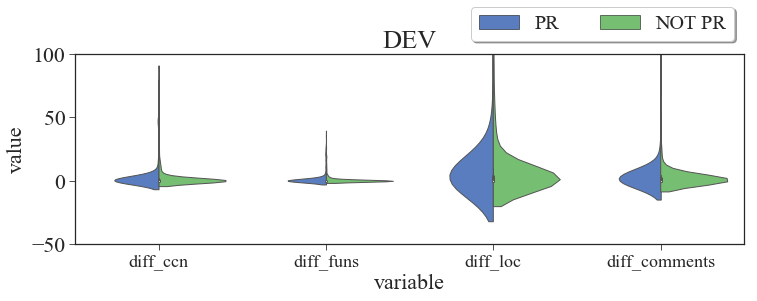

In [433]:
df_tmp0=pd.melt(commits.query('is_test == 0 '), id_vars=['is_test','in_pr'], value_vars=['diff_ccn','diff_funs','diff_loc','diff_comments'])

df_tmp0['in_pr']=df_tmp0['in_pr'].apply(lambda x: 'PR' if x
                                       else "NOT PR")
ax = sns.violinplot(split=True, x="variable", y="value",  data=df_tmp0, hue='in_pr', palette="muted", linewidth=1)
ax.figure.set_size_inches(12,3.5)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(-50,100)
ax.set_title('DEV')


In [434]:
commits2=commits.query('is_test == 0 ')
for x in ['diff_ccn','diff_funs','diff_loc','diff_comments']:
    print(x)
    #print(commits2.query('in_pr == 1')[x].mean(),commits2.query('in_pr == 0')[x].mean())
    print(scipy.stats.mannwhitneyu(commits2.query('in_pr == 1')[x],commits2.query('in_pr == 0')[x]))
    print(cliffsDelta(commits2.query('in_pr == 1')[x],commits2.query('in_pr == 0')[x]))

diff_ccn
MannwhitneyuResult(statistic=129201.0, pvalue=9.3141815808702434e-05)
d=0.13011189960007002
False
diff_funs
MannwhitneyuResult(statistic=133695.5, pvalue=0.00080147613826771604)
d=0.09985120450291532
False
diff_loc
MannwhitneyuResult(statistic=107194.0, pvalue=4.2110901458973045e-13)
d=0.2782812436879738
True
diff_comments
MannwhitneyuResult(statistic=109364.0, pvalue=1.1318221392515434e-13)
d=0.2636710070964006
True


Text(0.5,1,'TEST')

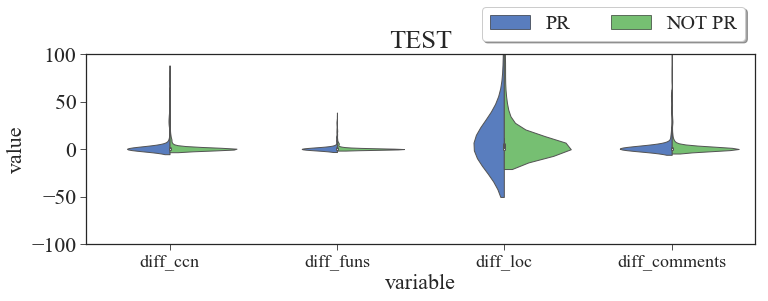

In [435]:
df_tmp0=pd.melt(commits.query('is_test == 1 '), id_vars=['is_test','in_pr'], value_vars=['diff_ccn','diff_funs','diff_loc','diff_comments'])

df_tmp0['in_pr']=df_tmp0['in_pr'].apply(lambda x: 'PR' if x
                                       else "NOT PR")
ax = sns.violinplot(split=True, x="variable", y="value",  data=df_tmp0, hue='in_pr', palette="muted", linewidth=1)
ax.figure.set_size_inches(12,3.5)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(-100,100)
ax.set_title('TEST')


In [436]:
commits2=commits.query('is_test == 1 ')
for x in ['diff_ccn','diff_funs','diff_loc','diff_comments']:
    print(x)
    #print(commits2.query('in_pr == 1')[x].mean(),commits2.query('in_pr == 0')[x].mean())
    print(scipy.stats.mannwhitneyu(commits2.query('in_pr == 1')[x],commits2.query('in_pr == 0')[x]))
    print(cliffsDelta(commits2.query('in_pr == 1')[x],commits2.query('in_pr == 0')[x]))

diff_ccn
MannwhitneyuResult(statistic=121508.5, pvalue=0.01967017961434318)
d=0.0672421469585777
False
diff_funs
MannwhitneyuResult(statistic=118944.0, pvalue=0.0031803072960564513)
d=0.08692848589062548
False
diff_loc
MannwhitneyuResult(statistic=105161.0, pvalue=1.7215930253290285e-07)
d=0.19273344182761692
True
diff_comments
MannwhitneyuResult(statistic=111513.5, pvalue=1.2426468207075484e-05)
d=0.1439685878343108
False


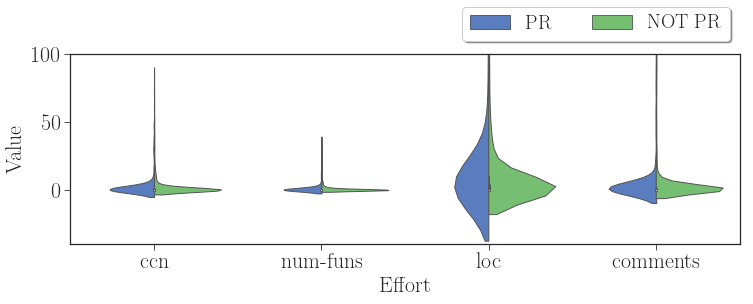

In [467]:
df_tmp0=pd.melt(commits, id_vars=['is_test','in_pr'], value_vars=['ccn','num-funs','loc','comments'])

df_tmp0['in_pr']=df_tmp0['in_pr'].apply(lambda x: 'PR' if x
                                       else "NOT PR")
ax = sns.violinplot(split=True, x="variable", y="value",  data=df_tmp0, hue='in_pr', palette="muted", linewidth=1)
ax.figure.set_size_inches(12,3.5)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(-40,100)
ax.set_xlabel('Effort')
ax.set_ylabel('Value')

ax.figure.savefig('../../../violinplots.png', bbox_inches='tight', facecolor='white')

In [469]:
we found that commits from PR require a bit more effort in terms of LOC and Comments (i.e statistically significant effect size) than other commits.
for x in ['ccn','num-funs','loc','comments']:
    print(x)
    #print(commits2.query('in_pr == 1')[x].mean(),commits2.query('in_pr == 0')[x].mean())
    print(scipy.stats.mannwhitneyu(commits.query('in_pr == 1')[x],commits.query('in_pr == 0')[x]))
    print(cliffsDelta(commits.query('in_pr == 1')[x],commits.query('in_pr == 0')[x]))

ccn
MannwhitneyuResult(statistic=508539.5, pvalue=3.5231366509822453e-05)
d=0.09469856783002661
False
num-funs
MannwhitneyuResult(statistic=508368.5, pvalue=1.0819764005793413e-05)
d=0.09500298183307075
False
loc
MannwhitneyuResult(statistic=431685.0, pvalue=5.6710305199150268e-18)
d=0.23151486020988543
True
comments
MannwhitneyuResult(statistic=449754.5, pvalue=3.9680738183819605e-16)
d=0.19934755712213054
True


Efforts:
The scam_efforts.json relates information about issues, pull requests (merged), commits and code complexity. The idea is to assess whether the development effort (measured with the diff of functions, LOC and cyclomatic complexity with the snapshot prior to the pull request commit) is related to the time to close (fields created_at, closed_at) and review an issue (fields date, prev_date, merged_at). 

Ideally, the output of this analysis should be (i) a bar chart containing all development efforts ordered by ascending date and (ii) a box plot that correlates the time needed to close/review issues with the efforts. Note that you can also use the variable is_test to perform the same analysis between test and no test code.

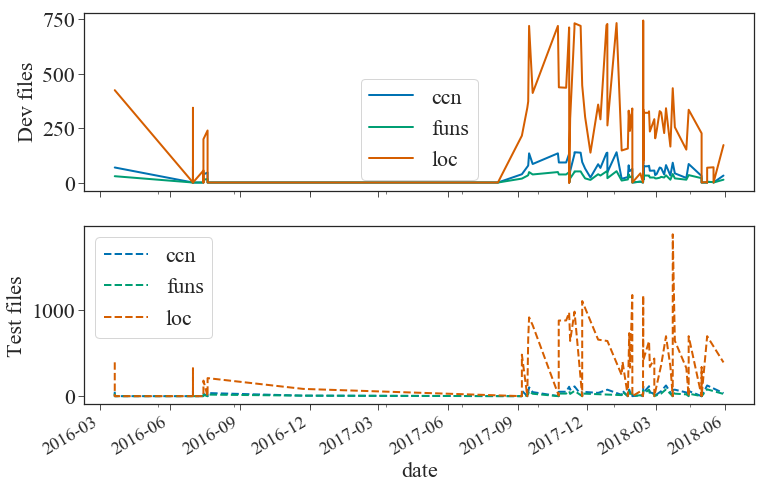

In [197]:
# Evolution of the ccn, funs, loc over time
df_tmp=efforts[['date','ccn','funs','is_test','loc']]
df_tmp.set_index('date', inplace=True)
figure, axes = plt.subplots(2,1, sharex=True, sharey=False)


df_tmp_0=df_tmp.query('is_test == 0').drop(['is_test'], axis=1)
ax=df_tmp_0.plot( linewidth=2, ax=axes[0])
ax.set_ylabel('Dev files')


df_tmp_0=df_tmp.query('is_test == 1').drop(['is_test'], axis=1)
ax=df_tmp_0.plot( linewidth=2, linestyle='--', label='Test ', ax=axes[1])
ax.set_ylabel('Test files')

ax.figure.set_size_inches(12,8)


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


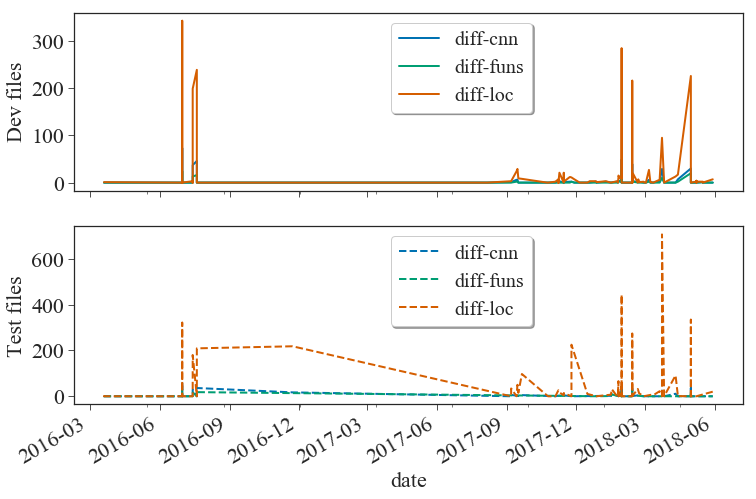

In [473]:
# Evolution of the dif_ccn, diff_funs, dif_loc over time
df_tmp=efforts[['date','diff_ccn','diff_funs','is_test','diff_loc']]
df_tmp.rename(columns={'diff_ccn':'diff-cnn','diff_funs':'diff-funs','diff_loc':'diff-loc'}, inplace=True)
df_tmp.set_index('date', inplace=True)
figure, axes = plt.subplots(2,1, sharex=True, sharey=False)


df_tmp_0=df_tmp.query('is_test == 0').drop(['is_test'], axis=1)
ax=df_tmp_0.plot( linewidth=2, ax=axes[0])
ax.set_ylabel('Dev files')
ax.legend(loc='upper right', bbox_to_anchor=(0.7, 1), fontsize=20, fancybox=True, shadow=True)


df_tmp_0=df_tmp.query('is_test == 1').drop(['is_test'], axis=1)
ax=df_tmp_0.plot( linewidth=2, linestyle='--', label='Test ', ax=axes[1])
ax.set_ylabel('Test files')
ax.legend(loc='upper right', bbox_to_anchor=(0.7, 1), fontsize=20, fancybox=True, shadow=True)

ax.figure.set_size_inches(12,8)


In [357]:
efforts.head(2)[['closed_at','merged_at','date']]

,closed_at,merged_at,date
0,2017-11-22 13:05:38,2017-11-22 13:05:37,2017-11-22 12:23:18
1,2017-11-28 11:17:01,2017-11-28 11:17:01,2017-11-28 09:58:14


In [484]:
#efforts['time']= efforts.apply(lambda d: (d['merged_at'] - d['date']).seconds/3600., axis=1)
efforts['time']= efforts.apply(lambda d: (d['closed_at'] - d['created_at']).seconds/3600.0, axis=1)

df_tmp=efforts[['time','diff_ccn','diff_funs','is_test','diff_loc']]
df_tmp['is_test']=df_tmp['is_test'].apply(lambda x: 'Test' if x
                                         else 'Development')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [485]:
df_tmp0=pd.melt(df_tmp, id_vars=['is_test','time'], value_vars=['diff_ccn','diff_funs','diff_loc'])
df_tmp0.head(2)

,is_test,time,variable,value
0,Development,0.681111,diff_ccn,2
1,Development,1.493056,diff_ccn,0


(-200, 200)

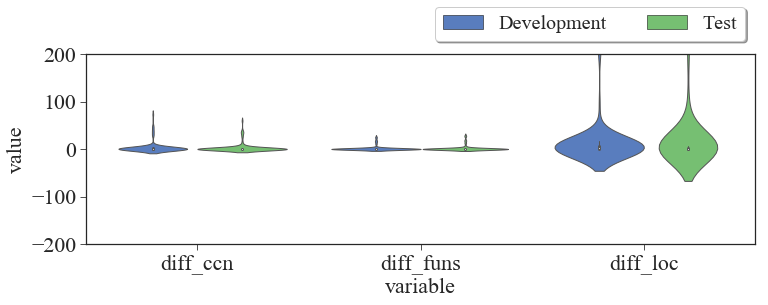

In [476]:
ax = sns.violinplot(x="variable", y="value",  data=df_tmp0, hue='is_test', palette="muted", linewidth=1)
ax.figure.set_size_inches(12,3.5)
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(-200,200)


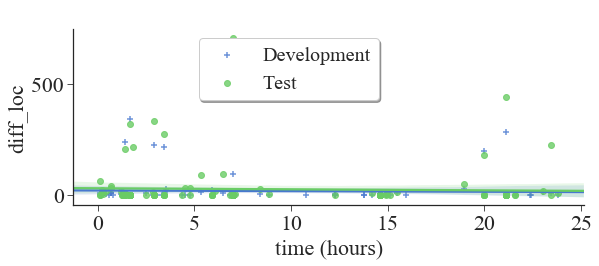

In [477]:

ax = sns.lmplot(x="time", y='diff_loc', markers=["+", 'o'], hue="is_test", 
                 palette='muted', data=df_tmp, legend='',
                size=8)
ax.set(xlabel='time (hours)')
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.6, 1.1), fontsize=20, fancybox=True, shadow=True)# ,ncol=3)
ax.fig.set_size_inches(9,3)

#ax.set(xlim=(0,50), ylim=(0,100))

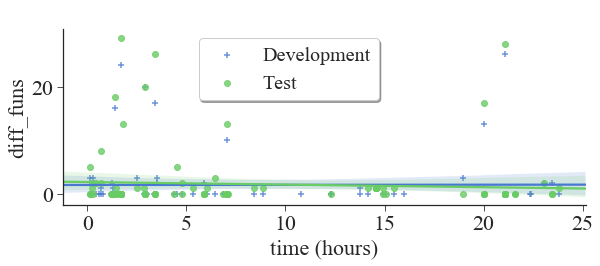

In [478]:

ax = sns.lmplot(x="time", y='diff_funs', markers=["+", 'o'], hue="is_test",
                 palette='muted', data=df_tmp, legend='',
                size=8)
ax.set(xlabel='time (hours)')
ax.fig.set_size_inches(9,3)
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.6, 1.1), fontsize=20, fancybox=True, shadow=True)# ,ncol=3)




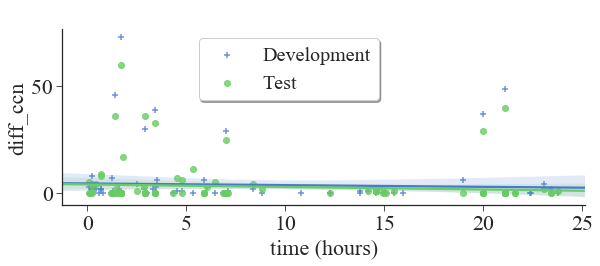

In [479]:
ax = sns.lmplot(x="time", y='diff_ccn', markers=["+", 'o'], hue="is_test",
                 palette='muted', data=df_tmp, legend='',
                size=8)
ax.set(xlabel='time (hours)')
ax.fig.set_size_inches(9,3)
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.6, 1.1), fontsize=20, fancybox=True, shadow=True)# ,ncol=3)

In [480]:

#df_tmp=efforts[['time','diff_ccn','diff_funs','is_test','diff_loc']]
print('is_test == 0')
df_tmp=efforts.query('is_test == 0')
for x in ['diff_ccn','diff_funs','diff_loc']:
    print(x,scipy.stats.spearmanr(df_tmp.time, df_tmp[x]))
    
print('is_test == 1')
df_tmp=efforts.query('is_test == 1')
for x in ['diff_ccn','diff_funs','diff_loc']:
    print(x,scipy.stats.spearmanr(df_tmp.time, df_tmp[x]))

is_test == 0
diff_ccn SpearmanrResult(correlation=-0.048872718236784213, pvalue=0.61213441513819367)
diff_funs SpearmanrResult(correlation=0.21336097357297157, pvalue=0.025219581291850712)
diff_loc SpearmanrResult(correlation=0.0034746441269329206, pvalue=0.97126148329470552)
is_test == 1
diff_ccn SpearmanrResult(correlation=0.0036595365137736015, pvalue=0.96639927412251181)
diff_funs SpearmanrResult(correlation=0.021703932216484641, pvalue=0.80269456714730125)
diff_loc SpearmanrResult(correlation=-0.043698804941773167, pvalue=0.61478616253280727)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1506: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


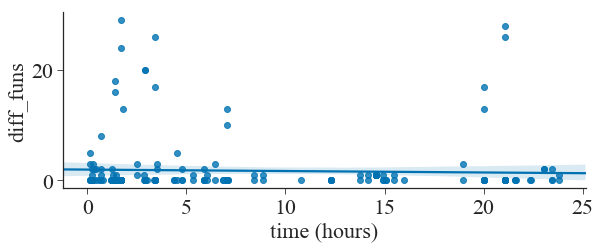

In [491]:
ax = sns.lmplot(x="time", y='diff_funs', 
                 palette='muted', data=efforts, legend='',
                size=8)
ax.set(xlabel='time (hours)')
ax.fig.set_size_inches(9,3)
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.6, 1.1), fontsize=20, fancybox=True, shadow=True)# ,ncol=3)

In [499]:
for x in ['diff_ccn','diff_funs','diff_loc']:
    print(x,'vs time ----- coef =',scipy.stats.spearmanr(efforts.time, efforts[x])[1], '----- spearmanr')

diff_ccn vs time ----- coef = 0.617982486875 ----- spearmanr
diff_funs vs time ----- coef = 0.102456220407 ----- spearmanr
diff_loc vs time ----- coef = 0.340229630439 ----- spearmanr


In [493]:
for x in ['diff_ccn','diff_funs','diff_loc']:
    print(x,'vs time',scipy.stats.pearsonr(efforts.time, efforts[x])[1])

diff_ccn vs time 0.215078935261
diff_funs vs time 0.526144342686
diff_loc vs time 0.584405767126


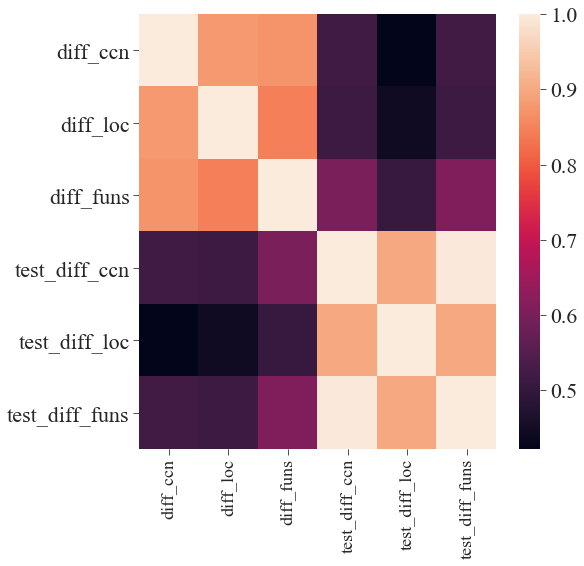

In [309]:



df_tmp0=efforts.query('is_test == 0')[['hash','diff_ccn','diff_loc','diff_funs']]

df_tmp1=efforts.query('is_test == 1')[['hash','diff_ccn','diff_loc','diff_funs']]

df_tmp1=df_tmp1.rename(columns={'diff_ccn':'test_diff_ccn','diff_loc':'test_diff_loc',
                                                    'diff_funs':'test_diff_funs'})


df_tmp01= (df_tmp0.
           merge(df_tmp1,
                 left_on='hash',
                 right_on='hash',
                 how='outer').
           drop_duplicates().
           dropna()
          )

df_tmp01.drop('hash',axis=1, inplace=True)
#df_tmp=df_tmp01[['ccn','num_funs','loc','comments','test_ccn','test_num_funs','test_loc','test_comments']]
corr=df_tmp01.corr('spearman')
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


ax.figure.set_size_inches(8,8)

#ax.figure.savefig('../../seneca_research/docker_debian/figures/all_bugs.pdf', bbox_inches='tight', facecolor='white')

In [310]:
corr

,diff_ccn,diff_loc,diff_funs,test_diff_ccn,test_diff_loc,test_diff_funs
diff_ccn,1.000000,0.879249,0.872837,0.519515,0.421550,0.522420
diff_loc,0.879249,1.000000,0.845468,0.515797,0.445322,0.513624
diff_funs,0.872837,0.845468,1.000000,0.601123,0.506647,0.608180
test_diff_ccn,0.519515,0.515797,0.601123,1.000000,0.902674,0.997327
test_diff_loc,0.421550,0.445322,0.506647,0.902674,1.000000,0.901655
test_diff_funs,0.522420,0.513624,0.608180,0.997327,0.901655,1.000000


In [236]:

#df_tmp=efforts[['time','diff_ccn','diff_funs','is_test','diff_loc']]
print('is_test == 0')
df_tmp=efforts.query('is_test == 0')
for x in ['diff_ccn','diff_funs','diff_loc']:
    print(x,scipy.stats.spearmanr(df_tmp.time, df_tmp[x]))
    
print('is_test == 1')
df_tmp=efforts.query('is_test == 1')
for x in ['diff_ccn','diff_funs','diff_loc']:
    print(x,scipy.stats.spearmanr(df_tmp.time, df_tmp[x]))

is_test == 0
diff_ccn SpearmanrResult(correlation=-0.32397959879142674, pvalue=0.00055495336289212397)
diff_funs SpearmanrResult(correlation=-0.46499213661167915, pvalue=3.0904755761810579e-07)
diff_loc SpearmanrResult(correlation=-0.33827721846151471, pvalue=0.00030090674552561431)
is_test == 1
diff_ccn SpearmanrResult(correlation=-0.39521383408586219, pvalue=2.0968613587236846e-06)
diff_funs SpearmanrResult(correlation=-0.39516239458511443, pvalue=2.1038424535166869e-06)
diff_loc SpearmanrResult(correlation=-0.27917291741960737, pvalue=0.001041833351959152)


# Tests
The scam_tests.json aims at measuring the evolution of code metrics (functions, LOC and comments) between test and no test code across every snapshot of a software project. Note that 
time aggreation is not possible, because there is the risk to sum up code metrics of files that changed many times in the timeframe selected (e.g., day, week, month). Thus, the idea is to sample the data frame in a way similar to this one:
 df_groups.drop(df_groups.index[[i for i in range(0, len(df_groups)) if i % 100 != 0]])
 
Ideally, the output of this analysis should be (i) a bar chart containing the evolution of the code metrics aforementioned and (ii) a box plot that correlates the metrics for test and no test code (is_test variable).

In [365]:
df_tmp.head()

,hash,commit_date,is_test,ccn,comments,loc,num_funs
0,000cac6f655f46cb489787fea8f06165923f3656,2016-02-24 17:01:50,0,346,1034,1820,138
1,000cac6f655f46cb489787fea8f06165923f3656,2016-02-24 17:01:50,1,171,332,1347,106
2,0036ac970da49f8ecb666b16f26de4415d5ad19d,2016-11-22 17:48:54,0,1275,3047,6528,517
3,0036ac970da49f8ecb666b16f26de4415d5ad19d,2016-11-22 17:48:54,1,1052,1521,8270,558
4,004174d35992f6c920a069358fb0348428899fc1,2015-12-04 17:26:27,0,90,332,443,44


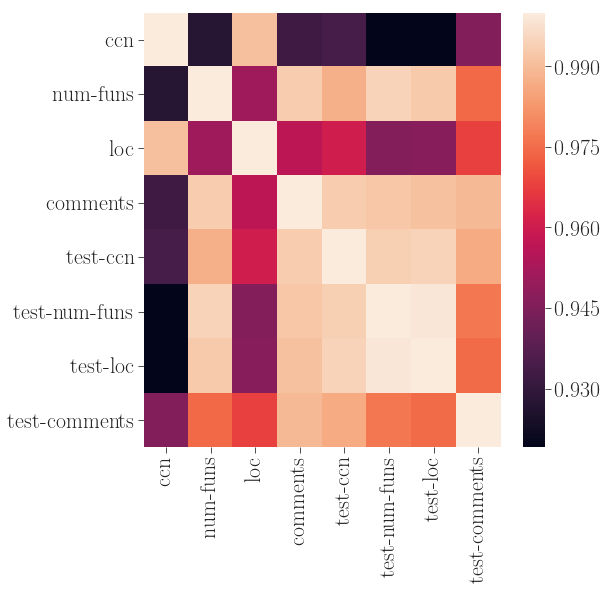

In [470]:


df_tmp = tests.groupby(['hash', 'commit_date', 'is_test'])['ccn', 'comments', 'loc', 'num_funs'].sum().reset_index()
#df_tmp=df_tmp.groupby(['commit_date','is_test']).first().reset_index()

df_tmp=df_tmp.rename(columns={'num_funs':'num-funs'})

df_tmp0=df_tmp.query('is_test == 0')

df_tmp1=df_tmp.query('is_test == 1').rename(columns={'ccn':'test-ccn','num-funs':'test-num-funs',
                                                    'loc':'test-loc','comments':'test-comments'})


df_tmp01= (df_tmp0.
           merge(df_tmp1,
                 left_on='hash',
                 right_on='hash',
                 how='outer').
           drop_duplicates().
           dropna()
          )


df_tmp01=df_tmp01[['ccn','num-funs','loc','comments','test-ccn','test-num-funs','test-loc','test-comments']]
corr=df_tmp01.corr('spearman')
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


ax.figure.set_size_inches(8,8)
ax.figure.savefig('../../../second_image.png', bbox_inches='tight', facecolor='white')

In [235]:
print(tests.hash.drop_duplicates().size,tests.commit_date.drop_duplicates().size)

1187 959


In [114]:
a=tests[['hash','commit_date']].drop_duplicates().groupby(['commit_date']).count().reset_index()
tests.query('commit_date=="2015-11-18 14:41:21"')['hash'].drop_duplicates()

40    47f9657b7e0cdb63c7c71aaba2edf0ce772145fe
51    740ca3d73893db8cf712b2dfff0df3af1600ae9b
64    d1253dd9876bb76e938a861acaceaae95241b46d
Name: hash, dtype: object

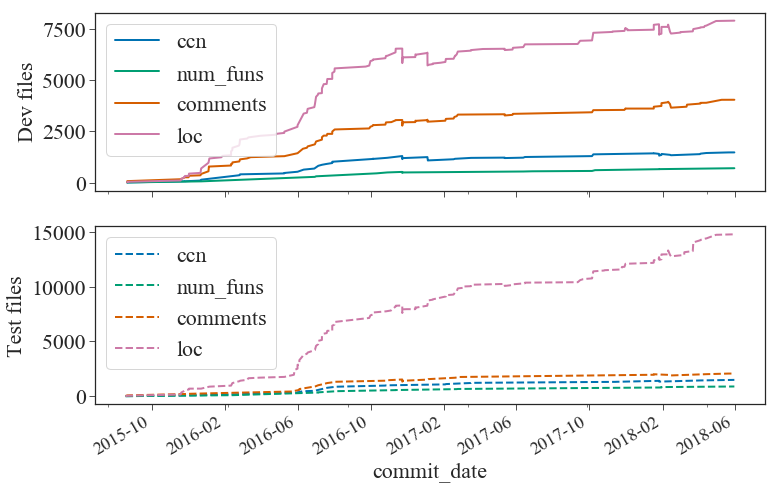

In [443]:
df_tmp = tests.groupby(['hash', 'commit_date', 'is_test'])['ccn', 'comments', 'loc', 'num_funs'].sum().reset_index()
df_tmp=df_tmp.groupby(['commit_date','is_test']).first().reset_index()

df_tmp['commit_date']= pd.to_datetime(df_tmp['commit_date'])

#df_tmp['commit_date']= df_tmp['commit_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

df_tmp.set_index('commit_date', inplace=True)

figure, axes = plt.subplots(2,1, sharex=True, sharey=False)


df_tmp_0=df_tmp.query('is_test == 0')
df_tmp_0=df_tmp_0[['ccn','num_funs','comments','loc']]

ax=df_tmp_0.plot( linewidth=2, ax=axes[0])
ax.set_ylabel('Dev files')


df_tmp_0=df_tmp.query('is_test == 1')
df_tmp_0=df_tmp_0[['ccn','num_funs','comments','loc']]

ax=df_tmp_0.plot( linewidth=2, linestyle='--', label='Test ', ax=axes[1])
ax.set_ylabel('Test files')

ax.figure.set_size_inches(12,8)
